# Top Performers Model 

This notebook documents the process of building a model to predict the top performers in the company. The model will be used to identify the top performers in the company and provide insights into the factors that contribute to their success. 
The model will be built using a demo dataset composed of metrics from Viva Insights, and we will be using a random forest classifier from `sklearn` for this purpose. 

## Set-up

We start off by loading in the required Python packages:

In [27]:
# data cleaning and utility
import numpy as np
import pandas as pd
import vivainsights as vi
import os

# visualizations
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D

# machine learning
from sklearn.ensemble import RandomForestClassifier # scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, auc, roc_curve
from sklearn.inspection import permutation_importance

The next step here is to load in the dataset, and then examine the data. In our local directory, we have a demo dataset that has a similar structure to a Person Query, with an additional 5-point scale 'performance' attribute that represents performance scores. 

`vi.import_query()` imports the demo person query data, and performs cleaning on the variable names. An alternative to this is to use `pd.read_csv()`, which does the same thing of reading in the input csv file. 

In [28]:
# Set relative path to go up one directory and into data folder
raw_data = vi.import_query(os.getcwd() + "\\..\\data\\Top_Performers_Dataset_v2.csv")

# Examine the data
raw_data.head() # first 5 rows

,PersonId,Internal_network_size,Collaboration_hours,weekend_collaboration_hours,After_hours_call_hours,performance
0,8c14b6ac-f043-39a6-9365-2898072a5951,79,130.04306,31.162695,0.0,5.0
1,8c14b6ac-f043-39a6-9365-2898072a5951,79,129.31995,31.000000,0.0,5.0
2,8c14b6ac-f043-39a6-9365-2898072a5951,79,128.94211,31.065472,0.0,5.0
3,8c14b6ac-f043-39a6-9365-2898072a5951,79,128.54636,31.032500,0.0,5.0
4,8c14b6ac-f043-39a6-9365-2898072a5951,79,127.14406,31.097500,0.0,5.0


## Data preparation

There are typically a number of data preparation and validation procedures involved before fitting a model, such as: 
- Handling missing values
- Changing variable types
- Handling outliers and unwanted data
- Splitting data into training and test sets

In this notebook, we will assume that the dataset is in decent quality, and all that is required are the standard procedures of changing variable types and splitting data into train/test sets. 

We start off by dropping any non-numeric columns (`PersonId` in this case). It is optional, but we also convert the `performance` variable into a binary variable (`perform_cat`), so we would yield a classification model. This step is for demo purposes as there are more use cases where the outcome variable is binary rather than ordinal or continuous. 

In [29]:
clean_data = raw_data.drop(columns=['PersonId']) # drop PersonId - not required for fitting
# Binary variable where >= 4 indicates High Performance
clean_data['perform_cat'] = np.where(clean_data['performance'] >= 4, 1, 0)


clean_data.head()

,Internal_network_size,Collaboration_hours,weekend_collaboration_hours,After_hours_call_hours,performance,perform_cat
0,79,130.04306,31.162695,0.0,5.0,1
1,79,129.31995,31.000000,0.0,5.0,1
2,79,128.94211,31.065472,0.0,5.0,1
3,79,128.54636,31.032500,0.0,5.0,1
4,79,127.14406,31.097500,0.0,5.0,1


The `train_test_split()` function from `sklearn.model_selection` makes it easy to split the data into training and test datasets. In the following example, the parameters are provided in this order: (i) data frame containing the predictor variables only, (ii) data frame containing the outcome variable only, and (iii) `test_size` controlling the proportion of the dataset to include in the train split.

This is assigned to four data frames:
- `x_train` - predictors, train set
- `x_test` - predictors, test set
- `y_train` - outcome, train set
- `y_test` - outcome, test set

In [30]:
# Split train and test data
outc_var_df = clean_data['perform_cat']
pred_var_df = clean_data.drop(columns=['perform_cat'])

x_train, x_test, y_train, y_test = train_test_split(pred_var_df, outc_var_df, test_size = 0.30)

## Fitting the model

The next step is to fit the random forest model, with `RandomForestClassifer()` from the `sklearn.ensemble` module.

After initializing the model and assigning to `rf`, we supply `x_train` and `y_train` to `fit()`, where the two variables represent the training data sets for the predictors and the outcome respectively.

Note that `RandomForestClassifier()` comes with many default parameters, which you can find out more [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html). We are using all the default parameters here, as we do not supply any additional parameters to `RandomForestClassifier()`.


In [31]:
rf = RandomForestClassifier()
rf.fit(x_train, y_train)

RandomForestClassifier()

## Evaluating the model

If no errors or warnings pop up, then the first iteration of the model is trained. The next step is to understand the model, and then to interpret and evaluate its outputs. 

Here are some metrics for assessing the model. These can be run from `sklearn.metrics`:

- **Accuracy**: This is the ratio of correct predictions to the total number of predictions. It's a good measure when the target variable classes in the data are nearly balanced. However, it can be misleading if the classes are imbalanced.

- **Precision**: Precision is the ratio of true positives (correctly predicted positive observations) to the total predicted positives. It's a measure of a classifier's exactness. A low precision indicates a high number of false positives.

- **Recall (Sensitivity)**: Recall is the ratio of true positives to the total actual positives. It's a measure of a classifier's completeness. A low recall indicates a high number of false negatives.

- **F1 Score**: The F1 Score is the weighted average of Precision and Recall. It tries to balance the two metrics. It's a good measure to use if you need to seek a balance between Precision and Recall and there is an uneven class distribution.

- **Confusion Matrix**: The confusion matrix is a table that is often used to describe the performance of a classification model on a set of data for which the true values are known. It contains information about actual and predicted classifications done by the classifier. It's a good way to visualize the performance of the model.

The choice of metric depends on your business objective. For example, if the cost of having false positives is high, the strategy might be to optimize for precision; this arguably applies to a top performers use case, where it is preferred that the model predicts fewer top performers. If the cost of missing positives (having false negatives) is high, the strategy might be to optimize for recall, which could be more relevant for an attrition use case.  

In [32]:
# Predict the labels for the test set
y_pred = rf.predict(x_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

# Print metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix:\n {conf_matrix}")

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Confusion Matrix:
 [[286   0]
 [  0  14]]


See below for a guide on how to interpret the confusion matrix:

A confusion matrix is a table that is often used to describe the performance of a classification model on a set of data for which the true values are known. In binary classification, the confusion matrix is a 2x2 matrix. Here's how to interpret it:

- The first row of the matrix represents the instances in the actual class (true class) - in this case, it's the negative class.
- The second row of the matrix represents the instances in the actual class (true class) - in this case, it's the positive class.
- The first column of the matrix represents the instances in the predicted class - in this case, it's the negative class.
- The second column of the matrix represents the instances in the predicted class - in this case, it's the positive class.

So, the confusion matrix looks like this:

|                    | Predicted Negative | Predicted Positive |
|--------------------|--------------------|--------------------|
| **Actual Negative**| True Negative (TN) | False Positive (FP)|
| **Actual Positive**| False Negative (FN)| True Positive (TP) |

- **True Positives (TP)**: These are cases in which we predicted yes (positive), and the actual was also yes (positive).
- **True Negatives (TN)**: We predicted no (negative), and the actual was also no (negative).
- **False Positives (FP)**: We predicted yes (positive), but the actual was no (negative). Also known as "Type I error".
- **False Negatives (FN)**: We predicted no (negative), but the actual was yes (positive). Also known as "Type II error".

The diagonal elements represent the number of points for which the predicted label is equal to the true label, while off-diagonal elements are those that are mislabeled by the classifier. The higher the diagonal values of the confusion matrix, the better, indicating many correct predictions.

## Variable importance

One of the major outputs of the Random Forest model is **feature importance**. 

Impurity-based feature importance and permutation-based feature importance are two different methods of calculating the importance of features in a machine learning model, each with its own strengths and weaknesses.

1. **Impurity-based Feature Importance (Mean Decrease Impurity, MDI)**: This method calculates the total amount that each feature decreases the impurity, averaged over all trees in the forest. The impurity decrease from each feature can be interpreted as the importance of that feature. This method is fast to compute and does not require a separate validation set or model re-fitting. However, it tends to inflate the importance of continuous features or high-cardinality categorical variables. It is also biased towards features with more categories.

2. **Permutation-based Feature Importance (Mean Decrease Accuracy, MDA)**: This method involves permuting the values of each feature one by one and measuring the decrease in the model's performance. The idea is that if a feature is important, permuting its values will drastically degrade the model's performance. This method is more reliable and has less bias towards continuous or high-cardinality features, but it is computationally expensive as it requires re-fitting the model for each feature, and it also requires a separate validation set.

In the context of Random Forest models in scikit-learn:

- The `feature_importances_` attribute of the `RandomForestClassifier` or `RandomForestRegressor` gives the impurity-based feature importance.
- The `permutation_importance` function from `sklearn.inspection` can be used to calculate the permutation-based feature importance.

### Impurity-based feature importance

Feature importances are provided by the fitted attribute `feature_importances_` and they are computed as the mean and standard deviation of accumulation of the impurity decrease within each tree.

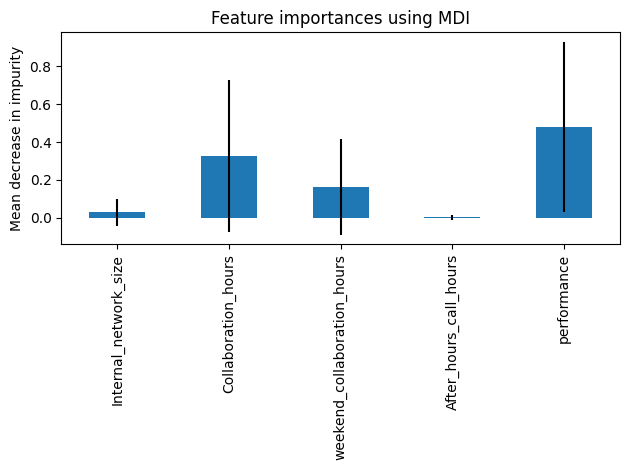

In [33]:
# Get feature importance
importance = rf.feature_importances_

# Summarize feature importance
forest_importances = pd.Series(importance, index=x_train.columns)
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

# Plot feature importance
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

### Feature permutation importance

Permutation feature importance overcomes limitations of the impurity-based feature importance: they do not have a bias toward high-cardinality features and can be computed on a left-out test set.

However, the computation for full permutation importance is more costly: features are shuffled n times and the model refitted to estimate the importance of it.

In [34]:
fpi_result = permutation_importance(
    rf, x_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

forest_importances = pd.Series(fpi_result.importances_mean, index=x_train.columns)

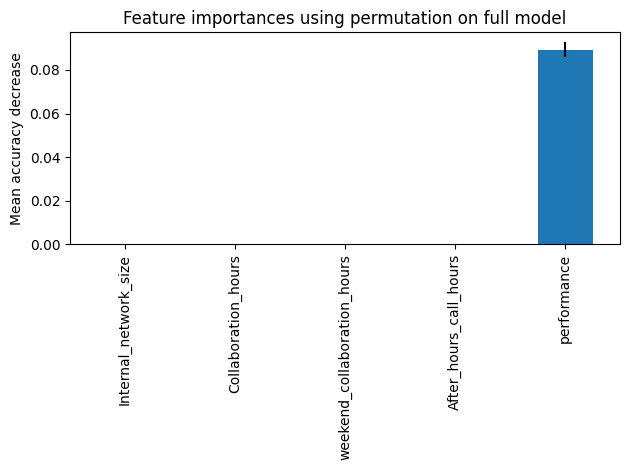

In [35]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=fpi_result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

# Tuning hyperparameters of the model

We can then tune the parameters of the random forest model to find the optimal values of the hyperparameters that maximize the performance and accuracy of the model. 

- `n_estimators`: The number of trees in the forest. A higher number of trees can improve the accuracy of the model, but it also increases the computational complexity and the risk of overfitting. Therefore, we need to find the optimal number of trees that balances the trade-off between performance and efficiency.
- `max_depth`: The maximum depth of each tree.
- `min_samples_split`: The minimum number of samples required to split a node.
- `min_samples_leaf`: The minimum number of samples required for a leaf node.
- `max_features`: The number of features to consider when looking for the best split.
- `criterion`: The function to measure the quality of a split.

Note that a hyperparameter is external to the model, and therefore is not itself an output of the ML model. 

In the following section, we will look at how to tune the number of estimators (trees), the max depth, the minimum samples split, and the minimum samples leaf.

In all the following plots, they will be measured against the Area Under the Curve (AUC) score, a model performance score ranging from 0 to 1. The AUC represents the likelihood that a classifier will assign a higher predicted probability to the positive class, compared to the negative class. 

To interpret the following plots: 

- Look at how the AUC scores change as the hyperparameter increases. If the AUC score increases with the hyperparameter, it means that increasing that hyperparameter is improving the model's performance.
- Compare the 'Train AUC' and 'Test AUC' series. If the 'Train AUC' is much higher than the 'Test AUC', it could indicate that the model is overfitting to the training data. If both series are close together, it suggests that the model is generalizing well to unseen data.

## Number of estimators

The plot below is showing how the Area Under the Curve (AUC) score of a Random Forest model changes as the number of estimators (i.e., the number of trees in the forest) increases. The 'Train AUC' series shows the AUC score on the training data, while the 'Test AUC' series shows the AUC score on the test data.

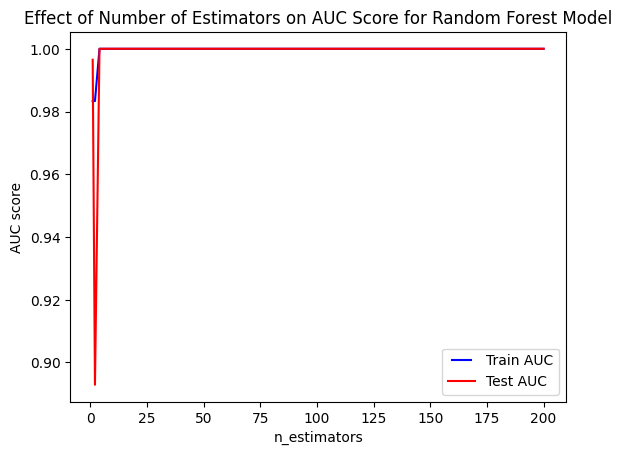

In [36]:
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]

train_results = []
test_results = []

for estimator in n_estimators:
    rf = RandomForestClassifier(n_estimators=estimator, n_jobs=-1)
    rf.fit(x_train, y_train)   
    train_pred = rf.predict(x_train)   
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)   
    y_pred = rf.predict(x_test)   
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
    
line1, = plt.plot(n_estimators, train_results, 'b', label='Train AUC')
line2, = plt.plot(n_estimators, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.title('Effect of Number of Estimators on AUC Score for Random Forest Model')
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.show()

## Max depth

The plot below is showing how the Area Under the Curve (AUC) score of a Random Forest model changes as the tree depth increases. The 'Train AUC' series shows the AUC score on the training data, while the 'Test AUC' series shows the AUC score on the test data.

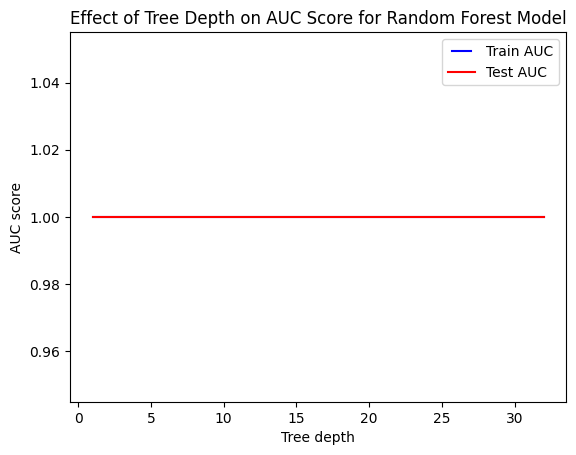

In [37]:
max_depths = np.linspace(1, 32, 32, endpoint=True).astype(int)

train_results = []
test_results = []

for max_depth in max_depths:
    rf = RandomForestClassifier(max_depth=max_depth, n_jobs=-1)
    rf.fit(x_train, y_train)       
    train_pred = rf.predict(x_train)   
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)    
    y_pred = rf.predict(x_test)        
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)    
    roc_auc = auc(false_positive_rate, true_positive_rate)    
    test_results.append(roc_auc)
 
line1, = plt.plot(max_depths, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_depths, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.title('Effect of Tree Depth on AUC Score for Random Forest Model')
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

## Minimum samples split

The following plot shows how the Area Under the Curve (AUC) score of a Random Forest model changes as the minimum samples split parameter changes. The 'Train AUC' series shows the AUC score on the training data, while the 'Test AUC' series shows the AUC score on the test data.

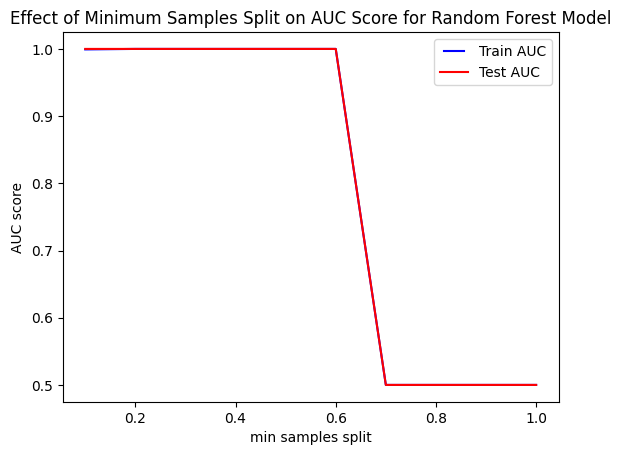

In [38]:
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)

train_results = []
test_results = []

for min_samples_split in min_samples_splits:
   rf = RandomForestClassifier(min_samples_split=min_samples_split)
   rf.fit(x_train, y_train)   
   train_pred = rf.predict(x_train)   

   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)

   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)   

   y_pred = rf.predict(x_test)   
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

line1, = plt.plot(min_samples_splits, train_results, 'b', label='Train AUC')
line2, = plt.plot(min_samples_splits, test_results, 'r', label='Test AUC')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.title('Effect of Minimum Samples Split on AUC Score for Random Forest Model')
plt.ylabel('AUC score')
plt.xlabel('min samples split')
plt.show()

## Minimum samples leaf

The following plot shows how the Area Under the Curve (AUC) score of a Random Forest model changes as the minimum samples leaf parameter changes. The 'Train AUC' series shows the AUC score on the training data, while the 'Test AUC' series shows the AUC score on the test data.

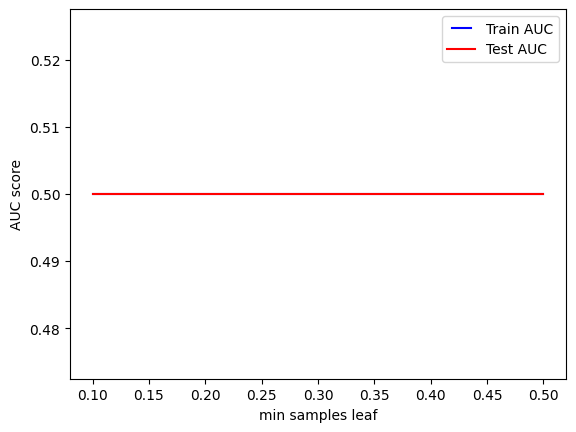

In [39]:
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
train_results = []
test_results = []

for min_samples_leaf in min_samples_leafs:
   rf = RandomForestClassifier(min_samples_leaf=min_samples_leaf)
   rf.fit(x_train, y_train)   
   train_pred = rf.predict(x_train)   
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)   
   y_pred = rf.predict(x_test)   
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

line1, = plt.plot(min_samples_leafs, train_results, 'b', label='Train AUC')
line2, = plt.plot(min_samples_leafs, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.title('Effect of Minimum Samples Leaf on AUC Score for Random Forest Model')
plt.ylabel('AUC score')
plt.xlabel('min samples leaf')
plt.show()